In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 1. Import Dataset

In [2]:
from torch.utils.data import DataLoader
from poc_data_v2 import PocDataset, display_sample


NUM_CASES = 2**8
BATCH_SIZE = 2**4

poc_raw_dataset = PocDataset(num_cases=NUM_CASES)
data_loader = DataLoader(dataset=poc_raw_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        pin_memory=True)

batch_data, batch_data_length, batch_event = next(iter(data_loader))

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)

torch.Size([16, 36, 5])
torch.Size([16, 1])
torch.Size([16, 1])


### Data Exploration

Length is 28, Event is 1
tensor([[  0.0000,  36.0000,  35.0000,   3.8321,  55.4579],
        [  1.0000,  36.0000,  34.0000,  18.2785, -16.2388],
        [  2.0000,  36.0000,  33.0000,  15.9197, -73.0055],
        [  3.0000,  36.0000,  32.0000,  -1.0756, -62.6514],
        [  4.0000,  36.0000,  31.0000, -17.0820,   5.3042],
        [  5.0000,  36.0000,  30.0000, -17.3833,  68.3831],
        [  6.0000,  36.0000,  29.0000,  -1.7024,  68.5909],
        [  7.0000,  36.0000,  28.0000,  15.5436,   5.7365],
        [  8.0000,  36.0000,  27.0000,  18.4989, -62.3919],
        [  9.0000,  36.0000,  26.0000,   4.4464, -73.1576],
        [ 10.0000,  36.0000,  25.0000, -13.6941, -16.6625],
        [ 11.0000,  36.0000,  24.0000, -19.2443,  55.1520],
        [ 12.0000,  36.0000,  23.0000,  -7.1014,  76.2600],
        [ 13.0000,  36.0000,  22.0000,  11.5705,  27.2549],
        [ 14.0000,  36.0000,  21.0000,  19.6045, -46.8083],
        [ 15.0000,  36.0000,  20.0000,   9.6143, -77.8361],
        [ 16.00

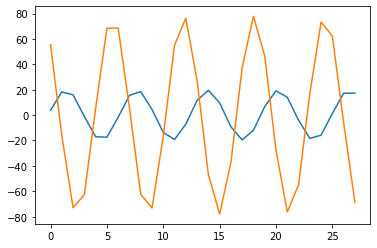

In [3]:
display_sample(batch_data[0], batch_data_length[0], batch_event[0])
print(batch_data[0])

Length is 28, Event is 1
Length is 7, Event is 1
Length is 11, Event is 1
Length is 25, Event is 1


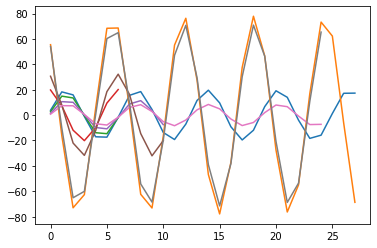

In [4]:
#Take a look at the longitudional data
display_sample(batch_data[0], batch_data_length[0], batch_event[0])
display_sample(batch_data[1], batch_data_length[1], batch_event[1])
display_sample(batch_data[2], batch_data_length[2], batch_event[2])
display_sample(batch_data[3], batch_data_length[3], batch_event[3])

### Test Sample

Length is 35, Event is 2


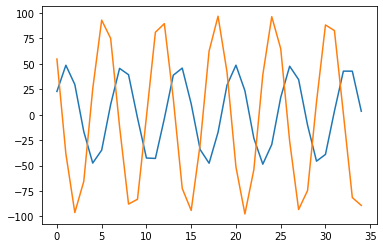

In [5]:
test_poc_raw_dataset = PocDataset(num_cases=1)
test_data_loader = DataLoader(dataset=test_poc_raw_dataset,batch_size=1,pin_memory=True)
test_batch_data, test_batch_data_length, test_batch_event = next(iter(test_data_loader))

display_sample(test_batch_data[0], test_batch_data_length[0], test_batch_event[0])

# 2. Hyperparameters

In [6]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from dynamicDeepHit import EncoderRNN, AttnDecoderRNN, CauseSpecificSubnetwork, DynamicDeepHit
from losses_v2 import loss_1_batch, loss_2_batch, loss_3_batch

NUM_EPOCHS = 1000

LEARNING_RATE_ENCODER = 0.001
LEARNING_RATE_DECODER = 0.001
LEARNING_RATE_CAUSESS = 0.0005

LOSS_1_AMPLIFIER = 0
LOSS_2_AMPLIFIER = 0
LOSS_3_AMPLIFIER = 1

RUN_VALIDATION_ROUND = False
VAL_NUM_CASES_RUNTIME = 2**3

input_size = 5
output_size = input_size
MAX_LENGTH = 36
NUM_CAUSES = 3
hidden_size_encoder = 512
hidden_size_attention = 512
fc_size_encoder = 512
SIGMA = 1

# 3. Defining The Model

In [7]:
# initialize model
encoder = EncoderRNN(input_size, hidden_size_encoder, fc_size_encoder).to(DEVICE)
decoder = AttnDecoderRNN(hidden_size_encoder, hidden_size_attention, output_size).to(DEVICE)
causess = CauseSpecificSubnetwork(hidden_size_encoder, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DDHT = DynamicDeepHit(encoder, decoder, causess, MAX_LENGTH, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER)
optimizer_decoder = Adam(decoder.parameters(), lr=LEARNING_RATE_DECODER)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS)
 
# initialize loss
writer = SummaryWriter()

# 4. Training the model

In [8]:
from torch import autograd

# start training
for epoch in trange(NUM_EPOCHS):

  epoch_loss = 0

  for batch_number, data in enumerate(test_data_loader):

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_decoder.zero_grad()
    optimizer_causess.zero_grad()

    batch_data, batch_data_length, batch_event = data
    batch_data = batch_data.to(DEVICE)
    batch_data_length = batch_data_length.to(DEVICE)
    batch_event = batch_event.to(DEVICE)
    
    output_batch, first_hitting_time_batch = DDHT(batch_data, batch_data_length)

    loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_data_length, MAX_LENGTH)
    loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)
    loss3 = LOSS_3_AMPLIFIER*loss_3_batch(output_batch, batch_data.detach())

    batch_loss = loss1 + loss2 + loss3
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    writer.add_scalar('train_loss1', loss1.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss2', loss2.item(), epoch*len(data_loader) + batch_number)
    writer.add_scalar('train_loss3', loss3.item(), epoch*len(data_loader) + batch_number)

    optimizer_encoder.step()
    optimizer_decoder.step()
    optimizer_causess.step()

  if RUN_VALIDATION_ROUND:
    # validating round
    DDHT.eval()

    with torch.no_grad():
      val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES_RUNTIME)
      val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=VAL_NUM_CASES_RUNTIME)
      val_batch_data, val_data_length, val_batch_event = next(iter(val_data_loader))
      val_batch_data = val_batch_data.to(DEVICE)
      val_data_length = val_data_length.to(DEVICE)
      val_batch_event = val_batch_event.to(DEVICE)

      val_output_batch, val_first_hitting_time_batch = DDHT(val_batch_data, val_data_length)

      val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_data_length, MAX_LENGTH)/VAL_NUM_CASES_RUNTIME
      val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_data_length, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
      val_loss3 = LOSS_3_AMPLIFIER*loss_3_batch(val_output_batch, val_batch_data.detach())/VAL_NUM_CASES_RUNTIME

      writer.add_scalar('val_loss1', val_loss1.item(), epoch)
      writer.add_scalar('val_loss2', val_loss2.item(), epoch)
      writer.add_scalar('val_loss3', val_loss3.item(), epoch)
      writer.add_scalar('val_epoch_loss', val_loss1.item() + val_loss2.item() + val_loss3.item(), epoch)

    DDHT.train()
    # end validating round

  writer.add_scalar('train_epoch_loss', epoch_loss.item(), epoch)
  


100%|██████████| 1000/1000 [01:14<00:00, 13.37it/s]


# 4. Testing the Model

### Predicting the test sample

In [9]:
#PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_3.pth"
#DDHT.load_state_dict(torch.load(PATH))

Length is 35, Event is 2
tensor([[ 22.8484,  54.7027],
        [ 48.5960, -38.4040],
        [ 29.6646, -96.2023],
        [-16.5402, -65.5526],
        [-47.5381,  25.3658]])


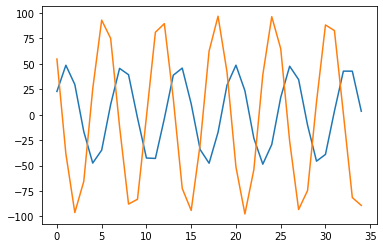

In [10]:
display_sample(test_batch_data[0], test_batch_data_length[0], test_batch_event[0])
print(test_batch_data[0,:5,3:])

Length is 35, Event is 2
tensor([[[  1.1845,  36.6715,  34.3669,  48.5133, -38.5525],
         [  2.0268,  36.2486,  33.1738,  29.5144, -96.3403],
         [  3.1287,  36.2027,  32.0297, -16.7997, -65.3212],
         [  4.1612,  36.1979,  31.0041, -47.7323,  25.8574],
         [  5.2002,  36.2446,  30.0158, -34.9930,  93.3939],
         [  6.1975,  36.1987,  28.9617,   9.7808,  75.3260],
         [  7.1540,  36.2060,  27.9987,  45.4645, -11.8731],
         [  8.0984,  36.1807,  26.9919,  39.2584, -87.9393],
         [  9.1097,  36.2046,  25.9883,  -3.0987, -83.2725],
         [ 10.1194,  36.2585,  24.9988, -42.8310,  -1.5052],
         [ 11.1406,  36.2271,  24.0345, -43.1500,  81.4250],
         [ 12.1816,  36.2242,  23.0154,  -4.0540,  89.9048],
         [ 13.1386,  36.2426,  22.0248,  38.7507,  15.8181],
         [ 14.0605,  36.1731,  21.0409,  45.7661, -72.6471],
         [ 15.0524,  36.1768,  20.0576,  10.5974, -94.2180],
         [ 16.1091,  36.2135,  19.0710, -34.5335, -28.7152],

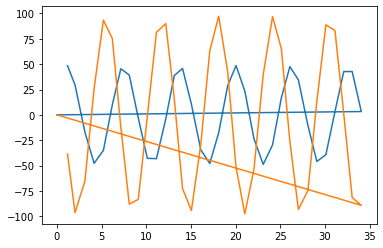

In [17]:
DDHT.eval();
test_encoder_output_vector, test_first_hitting_time = DDHT(test_batch_data.to(DEVICE), test_batch_data_length.to(DEVICE))
display_sample(test_encoder_output_vector[0].detach(), test_batch_data_length[0] - 1, test_batch_event[0])
print(test_encoder_output_vector)


In [12]:
print(torch.round(test_first_hitting_time * 10**2) / (10**2))
print(test_first_hitting_time.argmax().item())
print(test_first_hitting_time.shape)

tensor([[0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
         0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100]],
       device='cuda:0', gr

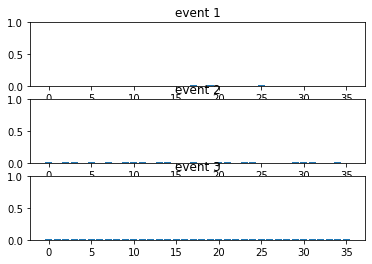

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[:MAX_LENGTH].cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[MAX_LENGTH:2*MAX_LENGTH].cpu().detach().numpy())
ax3.bar([i for i in range(MAX_LENGTH)], test_first_hitting_time.squeeze()[2*MAX_LENGTH:].cpu().detach().numpy())
ax1.set_title("event 1")
ax2.set_title("event 2")
ax3.set_title("event 3")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);
ax3.set_ylim([0,1]);

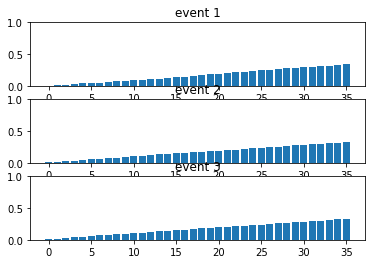

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[:MAX_LENGTH], dim=0).cpu().detach().numpy())
ax2.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[MAX_LENGTH:2*MAX_LENGTH], dim=0).cpu().detach().numpy())
ax3.bar([i for i in range(MAX_LENGTH)], torch.cumsum(test_first_hitting_time.squeeze()[2*MAX_LENGTH:], dim=0).cpu().detach().numpy())
ax1.set_title("event 1")
ax2.set_title("event 2")
ax3.set_title("event 3")
ax1.set_ylim([0,1]);
ax2.set_ylim([0,1]);
ax3.set_ylim([0,1]);

### Scoring our model

In [15]:
VAL_NUM_CASES = 2**6

val_poc_raw_dataset = PocDataset(num_cases=VAL_NUM_CASES)
val_data_loader = torch.utils.data.DataLoader(val_poc_raw_dataset,batch_size=2**6)
val_input_batch, val_event_batch, val_time_to_event_batch, _ = next(iter(val_data_loader))
val_input_batch = val_input_batch.to(DEVICE)
val_event_batch = val_event_batch.to(DEVICE)
val_time_to_event_batch = val_time_to_event_batch.to(DEVICE)


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
DDHT.eval()

val_output_batch, val_first_hitting_time_batch = DDHT(val_input_batch, val_time_to_event_batch)
val_loss1 = loss_1_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, MAX_LENGTH)/VAL_NUM_CASES
val_loss2 = loss_2_batch(val_first_hitting_time_batch, val_event_batch, val_time_to_event_batch, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES
val_loss3 = loss_3_batch(val_output_batch, val_input_batch.detach())/VAL_NUM_CASES


print("val_loss1=", val_loss1.item())
print("val_loss2=", val_loss2.item())
print("val_loss3=", val_loss3.item())


Records:
val_loss1= 0.09860126674175262
val_loss2= 16.080060958862305
val_loss3= 690.994384765625

In [ ]:
PATH = "C:/Users/marij/Desktop/THESIS ECO/DDHT/DDHT_pytorch/models/model_3.pth"
torch.save(DDHT.state_dict(), PATH)